In [2]:
"""Librairies nécessaires"""

import pandas as pd
from pandas import json_normalize
import geopandas as gpd

import numpy as np

import matplotlib.pyplot as plt

import json

from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points

In [3]:
"""Changement de directory pour lire les fichiers"""
import os
os.getcwd() #trouver le directory actuel 
os.chdir('/home/onyxia/work/Projet-Stat-App-2A')

In [5]:
"""Lecture du fichier des voies d'eau"""
emplacement = '3.0) Enrichissement données/Données/Voies_eau_paris.geojson'
df = gpd.read_file(emplacement, low_memory=False, index_col=0)

In [6]:
df_eau = df.copy()

In [20]:
df_eau.head(2)

,objectid,num_pave,igds_level,lib_level,lib_classe,nom_fichier,igds_basename,igds_style,igds_element_association_id,geom_origine,...,igds_fill_color,igds_fill_color_blue,igds_fill_color_green,igds_fill_color_red,igds_rotation,igds_graphic_group,st_area_shape,st_perimeter_shape,geo_point_2d,geometry
0,15,192E,32,DOMAINE PUBLIC ASSIMILE PARCELLE,Emprise voie d'eau : bassin,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3394.032853,563.743025,"{'lon': 2.3872675244873798, 'lat': 48.89052654...","POLYGON ((2.38723 48.89066, 2.38723 48.89066, ..."
1,18,153B,32,DOMAINE PUBLIC ASSIMILE PARCELLE,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.971254,8.813067,"{'lon': 2.2926541922858856, 'lat': 48.85077725...","POLYGON ((2.29267 48.85078, 2.29267 48.85077, ..."


In [49]:
"""Rassemblement en un seul polygone"""

union_polygon = df_eau.unary_union

# Créer un nouveau DataFrame GeoPandas avec le polygone résultant
df_eau_union = gpd.GeoDataFrame(geometry=[union_polygon], crs=df_eau.crs)

In [14]:
"""Chargement des données administratives de Paris intra muros"""

paris_arrondissement = gpd.read_file('2) Visualisation/Données_carto/paris_arrondissements.geojson')

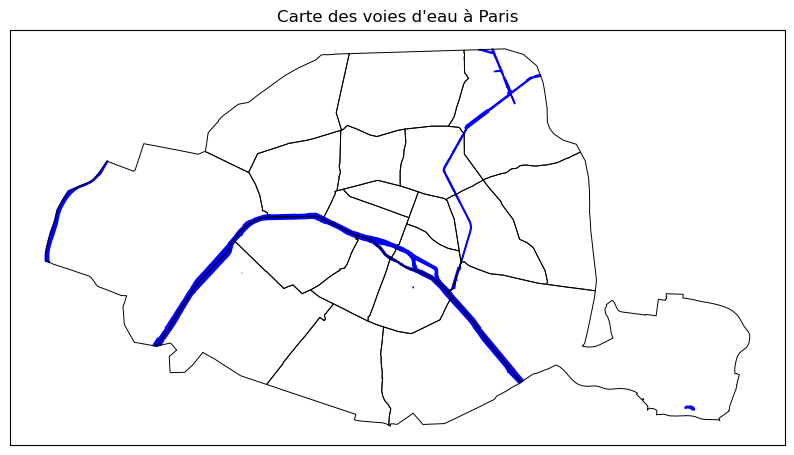

In [50]:
"""Visualisation des voies d'eau sur une carte"""

fig, ax = plt.subplots(figsize=(10, 8))

base = paris_arrondissement.boundary.plot(ax=ax, edgecolor = "black", linewidth = 0.7)
df_eau_union.plot(ax=ax, color='blue', alpha=1, edgecolor='blue', linewidth=1)

plt.xticks([], [])
plt.yticks([], [])

plt.title("Carte des voies d'eau à Paris")
plt.savefig('3.0) Enrichissement données/Sorties_cartes/carte_voies_eau.png')
plt.show()

In [54]:
"""Fonction qui merge les data set en trouvant la voie d'eau la plus proche 
et enregistre la distance (en km)"""

def ajout_voies_eau(dvf, df_eau):

    #sélection des variables
    var_eau = ['geometry']
    df_eau = df_eau[var_eau].copy()
    
    #Passer en projection 2D
    proj_lambert = 'EPSG:3942'
    dvf = dvf.to_crs(proj_lambert)
    df_eau = df_eau.to_crs(proj_lambert)

    #jointure spatiale
    merged_nearest = gpd.sjoin_nearest(dvf, df_eau, how="left", max_distance=6000, distance_col="dist_min_voie_eau")

    #dist en km
    merged_nearest['dist_min_voie_eau'] = merged_nearest['dist_min_voie_eau']/1000

    #repasser en système de projection wgs 84
    dvf_avec_voie_eau = merged_nearest.to_crs('EPSG:4326')

    #supprimer colonnes
    dvf_avec_voie_eau = dvf_avec_voie_eau.drop(['index_right'], axis=1)  

    #retirer les doublons
    #dvf_avec_voie_eau = dvf_avec_voie_eau.drop_duplicates(['id_mutation', 'log_prix', 'geometry'])

    return dvf_avec_voie_eau

In [24]:
"""Chargement fichier dvf"""

#chemin du fichier dvf
path_folder = '1.2) Données concat/'
name_file = 'dvf_concat_2021_to_2023.geojson'
path_file = path_folder + name_file

#lecture du fichier dvf
dvf = gpd.read_file(path_file)


In [55]:
"""Ajout des voies d'eau"""

dvf_avec_voie_eau = ajout_voies_eau(dvf, df_eau_union)

In [56]:
dvf_avec_voie_eau.shape

(59417, 21)

In [33]:
dvf.shape

(59417, 20)

In [57]:
"""Exportation"""

#chemin export
outer_path = '3.1) Données enrichies/'
outer_name = 'dvf_concat_2021_to_2023_avec_voie_eau.geojson'

#exportation
dvf_avec_voie_eau.to_file(outer_path+outer_name, driver='GeoJSON')